# Q-Table Learning
## FrozenLake

In [1]:
import gym
import numpy as np

In [2]:
env = gym.make('FrozenLake-v0')

## Implementing Q-Table Learning Algorithm
## Bellman Equation:
## Q(s,a) = r + γ(max(Q(s’,a’))
### the expected long-term reward for a given action is equal to the immediate reward from the current action combined with the expected reward from the best future action taken at the following state

In [33]:
#Initialize table with all zeros
Q = np.zeros([env.observation_space.n,env.action_space.n])
# Set learning parameters
lr = .8
y = .95
num_episodes = 2000
#create lists to contain total rewards and steps per episode
#jList = []
rList = []
for i in range(num_episodes):
    #Reset environment and get first new observation
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    #The Q-Table learning algorithm
    # try 99 times for each episode
    while j < 99:
        j+=1
        #Choose an action by greedily (with noise) picking from Q table
        # The noise will decrease while the iteration continues
        a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))
        #Get new state and reward from environment
        s1,r,d,_ = env.step(a)
        #Update Q-Table with new knowledge
        # bellman equation is brilliant!
        Q[s,a] = Q[s,a] + lr*(r + y*np.max(Q[s1,:]) - Q[s,a])
        rAll += r
        s = s1
        # break when dead
        if d == True:
            break
    #jList.append(j)
    rList.append(rAll)

In [21]:
print("Score over time: " +  str(sum(rList)/num_episodes))

Score over time: 0.5325


In [5]:
print("Final Q-Table Values: ")
print(Q)
# row: state
# column: action
# Q-Value of the state-action pair

Final Q-Table Values: 
[[3.25660976e-01 6.25871831e-03 1.20642075e-03 1.01218698e-02]
 [1.75818213e-03 0.00000000e+00 0.00000000e+00 3.36428246e-01]
 [4.38378535e-03 1.66293288e-01 7.91559496e-04 2.76287283e-03]
 [1.36626481e-06 1.00480931e-03 1.00146996e-03 8.95616580e-02]
 [2.44837411e-01 2.47493149e-03 2.47101529e-03 9.07063997e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.17057001e-03 6.70392701e-06 2.14591058e-04 5.17941169e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.18441960e-01]
 [4.72645047e-03 7.35627201e-01 1.69350291e-03 0.00000000e+00]
 [1.56238141e-01 0.00000000e+00 8.55715693e-05 1.46683466e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.76673005e-01 0.00000000e+00]
 [0.00000000e+00 9.50845009e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 

# Q-Network Learning
## FrozenLake

In [41]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
env = gym.make('FrozenLake-v0')

## Implmenting the network
## Loss = ∑(Q-target - Q)²

In [43]:
tf.reset_default_graph()

In [44]:
#These lines establish the feed-forward part of the network used to choose actions
# It's simply a full connected layer
inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4],0,0.01))
# Qout is a matrix with size [1, 4]
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

## Training the network

In [71]:
init = tf.global_variables_initializer()

# Set learning parameters
y = 1.2
e = 0.1
num_episodes = 2000
#create lists to contain total rewards and steps per episode
jList = []
rList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        #The Q-Network
        while j < 99:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            # input is a state which is generated from one-hot indexing
            # return an action and Q values for all actions
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
            
            # randomly sample out an action (give some noise to the model)
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
                
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a[0])
            
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            
            # targetQ is computed according to the reward of currentQ and 
            # the max Q of next state (how confident are we to take an action, 
            # the more confident we are, the more reward we can get after that)
            targetQ[0,a[0]] = r + y*maxQ1
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Percent of succesful episodes: 0.0155%


## Network performance

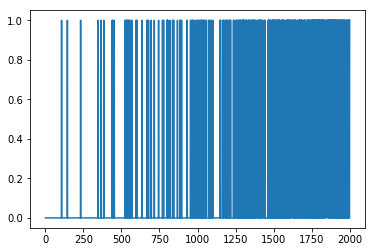

In [68]:
plt.plot(rList)

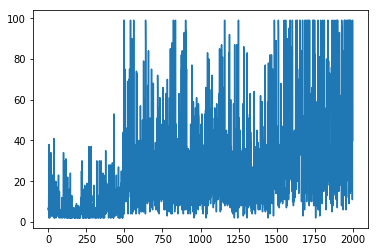

In [69]:
plt.plot(jList)